# Data preparation

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import Cdf
import Pmf


# suppress unnecessary warnings
import warnings
warnings.filterwarnings("ignore", module="numpy")

# define global plot parameters
params = {'axes.labelsize' : 12, 'axes.titlesize' : 12,
          'font.size' : 12, 'legend.fontsize' : 12,
          'xtick.labelsize' : 12, 'ytick.labelsize' : 12}
plt.rcParams.update(params)
plt.rcParams.update({'figure.max_open_warning': 0})


# connect to database and get data
conn = sqlite3.connect('data/youtube-traceroute.db')

# read necessary tables from database
date_cols = ['dtime']
deltas = pd.read_sql_query('select * from deltas', conn, parse_dates = date_cols)
conn.close()

# pad/fill missing data to display time series correctly
padded = pd.DataFrame(pd.date_range(start = '2016-05-15', end = '2018-05-31', freq = 'h'), columns = ['padded_time'])
deltas = pd.merge(deltas, padded, how = 'outer', left_on = 'dtime', right_on = 'padded_time')
deltas.drop('dtime', axis = 1, inplace = True)
deltas.rename(columns = { 'padded_time' : 'dtime' }, inplace = True)

# add new columns for year, month and day for more refined grouping
deltas['year'] = deltas['dtime'].dt.year
deltas['month'] = deltas['dtime'].dt.month
deltas['day'] = deltas['dtime'].dt.day

## Aggregated by month

### Deltas of metrics between IPv4 and IPv6

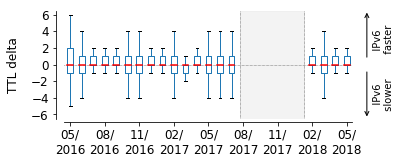

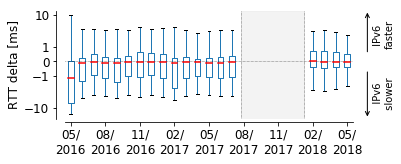

In [2]:
# pack relevant metrics and column names together
info = [('TTL', 'ttl_delta'),
        ('RTT', 'rtt_delta')]

# define data range for TTL deltas
ttl_yticks = range(-6, 7, 2)

# create plots for both metrics
for (metric, col) in info:
    # create plots
    ts_fig, ts_ax = plt.subplots(figsize = (5, 2))
    bp = deltas.boxplot(column = [col], by = ['year', 'month'], ax = ts_ax, sym = "", 
                        medianprops = { 'linewidth' : 1.5 }, return_type = 'dict')

    # workaround for changing color of median line
    for key in bp.keys():
        for item in bp[key]['medians']:
            item.set_color('red')

    # PLOT FORMATTING
    ts_fig.suptitle('')
    ts_ax.set_title('')  # ('%s time series' % metric)
    ts_ax.set_xlabel('')

    # labeling of y-axis for either TTL or RTT
    if metric == 'TTL':
        ts_ax.set_ylabel('TTL delta')
        ts_ax.set_ylim([-6.5, 6.5])
        ts_ax.yaxis.set_ticks(ttl_yticks)
        
        ts_ax.yaxis.labelpad = 11
        
    elif metric == 'RTT':
        ts_ax.set_yscale('symlog')
        ts_ax.set_ylabel('RTT delta [ms]')        
        
        from matplotlib.ticker import ScalarFormatter
        ts_ax.yaxis.set_major_formatter(ScalarFormatter())

    # adjust x-axis labeling and ticks
    major_ticklabels = ts_ax.xaxis.get_majorticklabels()
    for ticklabel in major_ticklabels:
        label = ticklabel.get_text()[1:-1]  # ignore ( ) at beginning and end of string
        y, m = label.split(', ')
        y = y[:-2]
        m = m[:-2]
        if int(m) in [5, 8, 11, 2]:  # skip a few months
            label = m.zfill(2) + '/\n' + y 
        else:
            label = ''
        ticklabel.set_text(label)
    
    # customize grid appearance
    ts_ax.grid(False)
    ts_ax.spines['right'].set_color('none')
    ts_ax.spines['top'].set_color('none')
    ts_ax.yaxis.set_ticks_position('left')
    ts_ax.xaxis.set_ticks_position('bottom')
    ts_ax.spines['bottom'].set_position(('axes', -0.03))
    ts_ax.spines['left'].set_position(('axes', -0.03))
    
    ts_ax.set_xticklabels(major_ticklabels, rotation = 0)
    
    # hide superfluous tick lines
    i = 0
    for t in ts_ax.xaxis.get_ticklines()[::1]:
        if i not in range(0, 50, 6):
            t.set_visible(False)
        i = i + 1
    
    # annotate plot to show directions where IPv6 is better/worse
    if metric == 'TTL':
        ts_ax.annotate('', xy = (1.05, 0.45),
                       xycoords = 'axes fraction',
                       xytext = (1.05, 0),
                       arrowprops = dict(arrowstyle = "<-"))
        ts_ax.annotate('', xy = (1.05, 1),
                       xycoords = 'axes fraction',
                       xytext = (1.05, 0.55),
                       arrowprops = dict(arrowstyle="->"))
        
        ts_ax.text(27.25, -4, "   IPv6\n slower", rotation = 90)
        ts_ax.text(27.25, 2.5, "   IPv6\n  faster", rotation = 90)
        
    elif metric == 'RTT':
        ts_ax.annotate('', xy = (1.05, 0.45),
                       xycoords = 'axes fraction',
                       xytext = (1.05, 0),
                       arrowprops = dict(arrowstyle = "<-"))
        ts_ax.annotate('', xy = (1.05, 1),
                       xycoords = 'axes fraction',
                       xytext = (1.05, 0.6),
                       arrowprops = dict(arrowstyle="->"))
        
        ts_ax.text(27.25, -3.5, "   IPv6\n slower", rotation = 90)
        ts_ax.text(27.25, 1.5, " IPv6\nfaster", rotation = 90)

    
    # dotted horizontal line to separate positive and negative delta region
    ts_ax.axhline(0, linestyle = 'dotted', color = 'black', linewidth = 0.5)

    ts_ax.axvspan(15.75, 21.25, alpha = 0.25, color = 'lightgrey')
    ts_ax.axvline(15.75, color = 'black', linestyle = 'dotted', linewidth = 0.5)
    ts_ax.axvline(21.25, color = 'black', linestyle = 'dotted', linewidth = 0.5)
    
    # saving and showing plot
    #ts_fig.savefig('plots/ts_%s_delta_by_month.pdf' % metric.lower(), bbox_inches = 'tight')
    plt.show()

plt.close('all')

### Absolute values of metrics

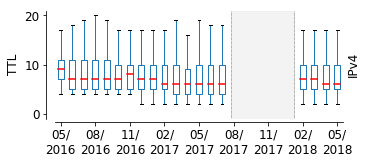

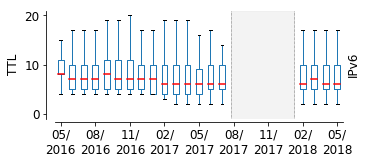

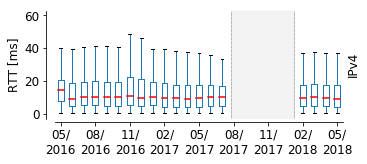

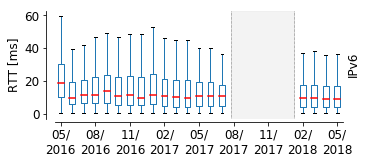

In [3]:
# pack relevant metrics, descriptors and column names together
info = [('TTL', 'IPv4', 'max(ttl)_v4'), 
        ('TTL', 'IPv6', 'max(ttl)_v6'), 
        ('RTT', 'IPv4', 'rtt_v4'), 
        ('RTT', 'IPv6', 'rtt_v6')]

# create plots for all tuples
for (metric, version, col) in info:
    # create plots
    ts_fig, ts_ax = plt.subplots(figsize = (5, 2))
    bp = deltas.boxplot(column = [col], by = ['year', 'month'], ax = ts_ax, sym = "", 
                        medianprops = { 'linewidth' : 1.5 }, return_type = 'dict')

    # workaround for changing color of median line
    for key in bp.keys():
        for item in bp[key]['medians']:
            item.set_color('red')

    # PLOT FORMATTING
    ts_fig.suptitle('')
    ts_ax.set_title('')  # ('%s time series' % metric)
    ts_ax.set_xlabel('')
    
    # labeling of y-axis for either TTL or RTT
    if metric == 'TTL':
        ts_ax.set_ylabel('TTL')
        ts_ax.set_ylim([-1, 21])
        
    elif metric == 'RTT':
        ts_ax.set_ylabel('RTT [ms]')
        ts_ax.set_ylim([-3, 63])
    
    # adjust x-axis labeling and ticks
    major_ticklabels = ts_ax.xaxis.get_majorticklabels()
    for ticklabel in major_ticklabels:
        label = ticklabel.get_text()[1:-1]  # ignore ( ) at beginning and end of string
        y, m = label.split(', ')
        y = y[:-2]
        m = m[:-2]
        if int(m) in [5, 8, 11, 2]:  # skip a few months
            label = m.zfill(2) + '/\n' + y 
        else:
            label = ''
        ticklabel.set_text(label)
    
    # customize grid appearance
    ts_ax.grid(False)
    ts_ax.spines['right'].set_color('none')
    ts_ax.spines['top'].set_color('none')
    ts_ax.yaxis.set_ticks_position('left')
    ts_ax.xaxis.set_ticks_position('bottom')
    ts_ax.spines['bottom'].set_position(('axes', -0.03))
    ts_ax.spines['left'].set_position(('axes', -0.03))
    
    ts_ax.set_xticklabels(major_ticklabels, rotation = 0)
    
    # add labeling for IP address family
    ax1_ = ts_ax.twinx()
    ax1_.spines['right'].set_color('none')
    ax1_.spines['top'].set_color('none')
    ax1_.spines['left'].set_color('none')
    ax1_.spines['bottom'].set_color('none')
    ax1_.yaxis.set_ticks_position('none')
    ax1_.set_ylabel('%s' % version)
    plt.setp(ax1_.get_yticklabels(), visible = False)
    
    # hide superfluous tick lines
    i = 0
    for t in ts_ax.xaxis.get_ticklines()[::1]:
        if i not in range(0, 50, 6):
            t.set_visible(False)
        i = i + 1
    
    ts_ax.axvspan(15.75, 21.25, alpha = 0.25, color = 'lightgrey')
    ts_ax.axvline(15.75, color = 'black', linestyle = 'dotted', linewidth = 0.5)
    ts_ax.axvline(21.25, color = 'black', linestyle = 'dotted', linewidth = 0.5)
    
    # saving and showing plot
    #ts_fig.savefig('plots/ts_%s_%s_by_month.pdf' % (metric.lower(), version[-2:]), bbox_inches = 'tight')
    
    plt.show()

plt.close('all')

### Absolutes in one single plot

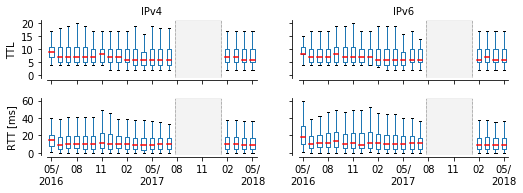

In [4]:
# update plot parameters to avoid oversizing too much
fsize = 10
params = {'axes.labelsize' : fsize, 'axes.titlesize' : fsize,
          'font.size' : fsize, 'legend.fontsize' : fsize,
          'xtick.labelsize' : fsize, 'ytick.labelsize' : fsize}
plt.rcParams.update(params)

# pack relevant plot coordinates, metrics, descriptors and column names together
info = [(0, 0, 'TTL', 'IPv4', 'max(ttl)_v4'), 
        (0, 1, 'TTL', 'IPv6', 'max(ttl)_v6'), 
        (1, 0, 'RTT [ms]', 'IPv4', 'rtt_v4'), 
        (1, 1, 'RTT [ms]', 'IPv6', 'rtt_v6')]

# create plot grid
ts_fig, ts_axes = plt.subplots(figsize = (8, 2.5), ncols = 2, nrows = 2)


# create plots for all tuples
for (i, j, metric, version, col) in info:
    # create plots
    bp = deltas.boxplot(column = [col], by = ['year', 'month'], ax = ts_axes[i, j], sym = "",
                        medianprops = { 'linewidth' : 1.5 }, return_type = 'dict')

    # workaround for changing color of median line
    for key in bp.keys():
        for item in bp[key]['medians']:
            item.set_color('red')

    # PLOT FORMATTING
    ts_axes[i, j].set_title('')
    ts_axes[i, j].set_xlabel('')
    
    # labeling of y-axis for either TTL or RTT
    if metric == 'TTL':
        ts_axes[i, j].set_ylim([-1, 21])
        ts_axes[i, j].set_yticks(np.arange(0, 21, 5))
    elif metric == 'RTT [ms]':
        ts_axes[i, j].set_ylim([-3, 63])
        ts_axes[i, j].set_yticks(np.arange(0, 61, 20))
        
    if j==0:
        ts_axes[i, j].set_ylabel(metric)
    else:
        ts_axes[i, j].set_yticklabels("")

    # adjust x-axis labeling and ticks
    major_ticklabels = ts_axes[i, j].xaxis.get_majorticklabels()
    for ticklabel in major_ticklabels:
        if i==0:
            ticklabel.set_text('')
        else:
            label = ticklabel.get_text()[1:-1]  # ignore ( ) at beginning and end of string
            y, m = label.split(', ')
            y = y[:-2]
            m = m[:-2]
            # format months to look nicely
            if int(m) in [5]:
                label = m.zfill(2) + '/\n' + y
            elif int(m) in [2, 8, 11]:
                label = m.zfill(2)
            else:
                label = ''
            ticklabel.set_text(label)           
              
    # customize grid appearance
    ts_axes[i, j].grid(False)
    ts_axes[i, j].spines['right'].set_color('none')
    ts_axes[i, j].spines['top'].set_color('none')
    ts_axes[i, j].yaxis.set_ticks_position('left')
    ts_axes[i, j].xaxis.set_ticks_position('bottom')
    ts_axes[i, j].spines['bottom'].set_position(('axes', -0.03))
    ts_axes[i, j].spines['left'].set_position(('axes', -0.03))
    
    ts_axes[i, j].set_xticklabels(major_ticklabels, rotation = 0)

    
    # hide superfluous tick lines
    n = 0
    for t in ts_axes[i, j].xaxis.get_ticklines()[::1]:
        if n not in range(0, 50, 6):
            t.set_visible(False)
        n = n + 1
        
    ts_axes[i, j].axvspan(15.75, 21.25, alpha = 0.25, color = 'lightgrey')
    ts_axes[i, j].axvline(15.75, color = 'black', linestyle = 'dotted', linewidth = 0.5)
    ts_axes[i, j].axvline(21.25, color = 'black', linestyle = 'dotted', linewidth = 0.5)
    
# set plot titles to finish
ts_axes[0, 0].set_title('IPv4')
ts_axes[0, 1].set_title('IPv6')

# add some space to not look too crammed
plt.subplots_adjust(hspace=0.35)

# remove figure title
ts_fig.suptitle('')


# saving and showing plot
ts_fig.savefig('plots/ts_by_month.pdf', bbox_inches = 'tight')
plt.show()

plt.close('all')